# Exploratory Data Analysis of Weather in Illinois

In [1]:
# Machine learning library
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# DataFrame library
import pandas as pd

# Array library
import numpy as np

# Plotting library
import matplotlib.pyplot as plt


In [2]:
# Loads the data based on the desired data types and columns
raw_weather_data = pd.read_parquet("./data/raw_weather.parquet", engine = "pyarrow")
raw_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19102488 entries, 0 to 19102487
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         string 
 1   date       string 
 2   time       string 
 3   element    string 
 4   value      float64
 5   qflag      string 
 6   latitude   float64
 7   longitude  float64
 8   name       string 
 9   elevation  float64
dtypes: float64(4), string(6)
memory usage: 1.4 GB


In [3]:
# The qflag represents quality of the measurement (we want the rows that don't have quality issues which is denoted <NA>)
raw_weather_data["qflag"].unique()

<StringArray>
[<NA>, 'I', 'L', 'D', 'S', 'O', 'W', 'K', 'X', 'G', 'M', 'Z', 'N', 'T', 'R']
Length: 15, dtype: string

In [4]:
# Unique elements to gather data from
# See the following website for more details https://docs.opendata.aws/noaa-ghcn-pds/readme.html#:~:text=SNWD%20%3D%20Snow%20depth%20(mm),temperature%20(tenths%20of%20degrees%20C)
raw_weather_data["element"].unique()

<StringArray>
['PRCP', 'SN32', 'SN52', 'SNOW', 'SNWD', 'SX32', 'SX52', 'TMAX', 'TMIN',
 'TOBS', 'WT01', 'WT03', 'WT04', 'WT06', 'WESD', 'WESF', 'WT11', 'WDF5',
 'WSFG', 'DAPR', 'TAVG', 'MDPR', 'AWND', 'WSF2', 'WSF5', 'WT05', 'WDF2',
 'WT02', 'WT08', 'EVAP', 'WDMV', 'WT18', 'PGTM', 'WDFG', 'MNPN', 'WT14',
 'MXPN', 'MDSF', 'MDEV', 'WT16', 'WT15', 'DAEV', 'WT07', 'WT09', 'MDWM',
 'WT17', 'DASF', 'DAWM', 'SX53', 'SN53', 'FMTM', 'TSUN', 'WT10', 'WT13',
 'RHAV', 'ADPT', 'ASLP', 'ASTP', 'RHMX', 'AWBT', 'RHMN', 'ACSH', 'WSF1',
 'WDF1', 'WT19', 'WV03', 'ACMH', 'WT21', 'WT22', 'WV20', 'SN12', 'SX12',
 'PSUN', 'SX03', 'SN02', 'SX02', 'SN03', 'WV18', 'WV01']
Length: 79, dtype: string

In [5]:
# Counts the total number of occurrences of an element for each element
element_count = raw_weather_data.groupby("element")["element"].count().sort_values()
element_count

element
WV01          1
WV18          1
PSUN          2
WT10         13
WV20         19
         ...   
TMIN    1678986
TMAX    1679778
SNWD    2695417
SNOW    3969024
PRCP    5189380
Name: element, Length: 79, dtype: int64

In [6]:
# Number of stations in Illinois
num_of_stations = raw_weather_data["name"].nunique()
num_of_stations

2005

In [7]:
raw_weather_data.shape

(19102488, 10)

In [8]:
# Replaces all nan values with "0000"
raw_weather_data["time"] = raw_weather_data["time"].fillna("0000")

In [9]:
# Verifies how many unique length characters there was in the "time" column
# There should only be one of length 4 characters to be able to parse into datetime format
np.sort(raw_weather_data["time"].apply(len).unique())

array([4])

In [10]:
# Adds a seconds placeholder for parsing
raw_weather_data["time"] = raw_weather_data["time"].apply(lambda x: f"{x[:-2]}:{x[-2:]}:00")

# Converts string format to datetime format for the time column
raw_weather_data["time"] = pd.to_timedelta(raw_weather_data["time"])

In [11]:
# Converts the string format to a datetime format for the date column
raw_weather_data["date"] = pd.to_datetime(raw_weather_data["date"])

# Combines date and time into the same column which can be accessed via object attributes
raw_weather_data["date"] = raw_weather_data["date"] + raw_weather_data["time"]

# Drops the redundant time column
raw_weather_data.drop(columns = ["time"], inplace = True)

# Drops the rows that have quality issues
raw_weather_data = raw_weather_data[raw_weather_data["qflag"].isna()].drop(columns = ["qflag"])

# Converts elevation in tenths of meters to feet
raw_weather_data["elevation"] = raw_weather_data["elevation"] / 10 * 3.281
raw_weather_data = raw_weather_data[raw_weather_data["date"].dt.year < raw_weather_data["date"].dt.year.max()]
raw_weather_data

,id,date,element,value,latitude,longitude,name,elevation
0,USC00112344,2007-05-13 07:00:00,PRCP,0.0,38.4628,-88.9433,DIX,60.20635
1,USC00118932,2007-12-07 14:00:00,PRCP,23.0,38.2133,-89.0850,WALTONVILLE,51.11798
2,USC00116753,2007-05-10 07:00:00,PRCP,0.0,41.3497,-89.1075,PERU,63.38892
3,USC00110993,2007-04-06 06:00:00,PRCP,0.0,37.1275,-88.6531,BROOKPORT DAM 52,33.00686
4,USC00118990,2007-06-15 07:00:00,PRCP,0.0,40.6994,-89.4478,WASHINGTON 2 W,75.49581
...,...,...,...,...,...,...,...,...
19102483,USC00112223,2016-11-26 07:00:00,PRCP,0.0,41.9342,-88.7756,DE KALB,87.79956
19102484,USC00112223,2016-01-28 00:00:00,SNWD,25.0,41.9342,-88.7756,DE KALB,87.79956
19102485,USC00112223,2016-06-14 00:00:00,WDMV,45.0,41.9342,-88.7756,DE KALB,87.79956
19102486,USC00112223,2016-06-25 07:00:00,EVAP,66.0,41.9342,-88.7756,DE KALB,87.79956


In [12]:
# Elements of interest
''' Minimum Temperature (units: tenths of Celsisus) (TMIN), Maximum Temperature (units: tenths of Celsisus) (TMAX), 
    Observed Temperature (units: tenths of Celsisus) (TOBS),
    Total Precipitation (PRCP), Total Snowfall (SNOW), Snow Depth (SNWD),
    and Total Sunshine (units: minutes) (TSUN)
'''
desired_elements = ["TMIN", "TMAX", "TOBS", "TSUN", "PRCP", "SNOW", "SNWD"]
desired_data = raw_weather_data[raw_weather_data["element"].isin(desired_elements)]

In [13]:
# Pivots the element values into columns which are more useful in column format
desired_weather_pivot = desired_data.pivot_table(
    index=["date", "id", "name", "latitude", "longitude", "elevation"], 
    columns="element", 
    values="value"
).reset_index()
desired_weather_pivot

element,date,id,name,latitude,longitude,elevation,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,TSUN
0,1990-01-01 00:00:00,USC00110055,ALBION,38.3778,-88.0569,52.98815,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1990-01-01 00:00:00,USC00110072,ALEDO,41.2069,-90.7419,73.39597,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1990-01-01 00:00:00,USC00110187,ANNA 4 N,37.5222,-89.2486,59.28767,NaN,28.0,0.0,NaN,NaN,NaN,NaN
3,1990-01-01 00:00:00,USC00110203,ANTIOCH,42.4811,-88.0994,75.00366,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1990-01-01 00:00:00,USC00110338,AURORA WATER,41.7803,-88.3092,67.49017,NaN,0.0,51.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7568524,2023-12-31 17:00:00,USC00114012,HENNEPIN,41.2542,-89.3378,51.51170,8.0,NaN,0.0,44.0,-22.0,6.0,NaN
7568525,2023-12-31 18:00:00,USC00111250,CANTON,40.5378,-90.0422,64.01231,0.0,NaN,0.0,NaN,NaN,NaN,NaN
7568526,2023-12-31 18:00:00,USC00111436,CHARLESTON,39.4761,-88.1653,70.01654,0.0,NaN,0.0,44.0,-11.0,-6.0,NaN
7568527,2023-12-31 18:00:00,USC00114198,HOOPESTON,40.4664,-87.6850,71.00084,0.0,NaN,0.0,17.0,-22.0,-6.0,NaN


In [14]:
# Define a mapping of element columns to their conversion formulas
conversion_map = {
    "TMIN": lambda x: 9/5 * (x / 10) + 32,   # tenths of Celsius to Fahrenheit
    "TMAX": lambda x: 9/5 * (x / 10) + 32,
    "TOBS": lambda x: 9/5 * (x / 10) + 32,
    "PRCP": lambda x: (x / 10) * (1 / 25.4), # tenths of mm to inches
    "SNOW": lambda x: x * (1 / 25.4),
    "SNWD": lambda x: x * (1 / 25.4),
}

for col, func in conversion_map.items():
    if col in desired_weather_pivot.columns:
        desired_weather_pivot[col] = func(desired_weather_pivot[col])

In [15]:
desired_weather_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7568529 entries, 0 to 7568528
Data columns (total 13 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   id         string        
 2   name       string        
 3   latitude   float64       
 4   longitude  float64       
 5   elevation  float64       
 6   PRCP       float64       
 7   SNOW       float64       
 8   SNWD       float64       
 9   TMAX       float64       
 10  TMIN       float64       
 11  TOBS       float64       
 12  TSUN       float64       
dtypes: datetime64[ns](1), float64(10), string(2)
memory usage: 750.7 MB


In [16]:
desired_weather_pivot.describe()

element,date,latitude,longitude,elevation,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,TSUN
count,7568529,7.568529e+06,7.568529e+06,7.568529e+06,5.187705e+06,3.967605e+06,2.693896e+06,1.671348e+06,1.662732e+06,1.417502e+06,28326.000000
mean,2009-07-29 00:19:16.973256192,4.041811e+01,-8.897403e+01,6.424341e+01,1.181941e-01,6.588578e-02,4.164255e-01,6.271153e+01,4.242761e+01,4.877967e+01,126.773353
min,1990-01-01 00:00:00,3.700440e+01,-9.142830e+01,2.700263e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.696000e+01,-3.802000e+01,-3.604000e+01,0.000000
25%,2002-06-18 00:00:00,3.944080e+01,-8.965110e+01,5.610510e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.604000e+01,2.894000e+01,3.398000e+01,0.000000
50%,2010-06-08 00:00:00,4.054920e+01,-8.886550e+01,6.499661e+01,0.000000e+00,0.000000e+00,0.000000e+00,6.602000e+01,4.298000e+01,5.000000e+01,0.000000
75%,2017-06-18 08:00:00,4.165980e+01,-8.818280e+01,7.221481e+01,3.937008e-02,0.000000e+00,0.000000e+00,8.096000e+01,5.900000e+01,6.494000e+01,69.000000
max,2023-12-31 22:00:00,4.250530e+01,-8.752850e+01,1.217907e+02,1.690945e+01,2.299213e+01,3.598425e+01,1.119200e+02,8.798000e+01,1.070600e+02,913.000000
std,NaN,1.389870e+00,9.241324e-01,1.276834e+01,3.349351e-01,4.906567e-01,1.652566e+00,2.093449e+01,1.898004e+01,1.960783e+01,242.137129


### This cell below plots the minimum, maximum, and observed temperatures.

#### Note: ``pandas.DataFrame.plot`` attribute can be used to shorten the time to make a plot. The tradeoff is less customization of the plot.

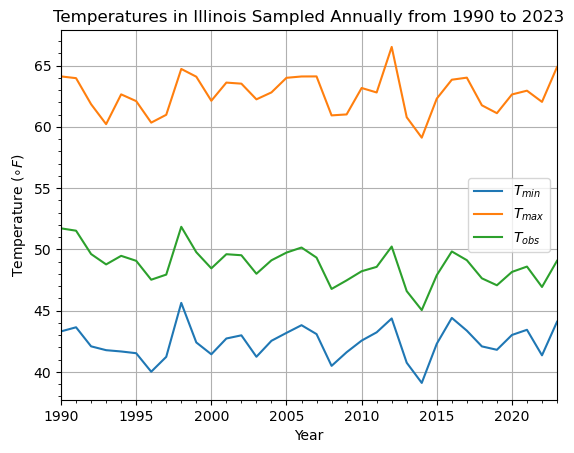

In [17]:
# Resamples the temperature data annually and calculate the mean
temp_data = desired_weather_pivot[["date", "TMIN", "TMAX", "TOBS"]]
resampled_temp_data = temp_data.resample(rule = "YE", on = "date").mean()
resampled_temp_data.index = pd.to_datetime(resampled_temp_data.index)
tmin_label = r"$T_{min}$"
tmax_label = r"$T_{max}$"
tobs_label = r"$T_{obs}$"

# Plots TMIN, TMAX, and TOBS
plt.plot(resampled_temp_data.index.year, resampled_temp_data["TMIN"], label = tmin_label)
plt.plot(resampled_temp_data.index.year, resampled_temp_data["TMAX"], label = tmax_label)
plt.plot(resampled_temp_data.index.year, resampled_temp_data["TOBS"], label = tobs_label)

# Sets labels and title
plt.xlabel("Year")
plt.ylabel(r"Temperature ($\circ F$)")
plt.title("Temperatures in Illinois Sampled Annually from 1990 to 2023")

# Displays the legend
plt.legend(loc="best")

# Fixes the x-range so that it's between 1990 and 2023
plt.xlim(resampled_temp_data.index.year.min(), resampled_temp_data.index.year.max())

# Displays the grid
plt.grid()

# Displays minor ticks
plt.minorticks_on()

# Shows the plot
plt.show()

In [18]:
def moving_avg_plot(df, window_interval):
    """Creates a moving average plot specified at a certain interval.

    Args:
        df (pandas.DataFrame): dataframe used to preform the rolling average plot
        window_interval (int): the amount of years we want to do the rolling average over (i.e. 1 year, 3 years, etc.)
    """
    

    moving_average_temp_data = df.rolling(window = window_interval, min_periods = 1).mean()


    # Plots TMIN, TMAX, and TOBS with moving averages
    plt.plot(moving_average_temp_data.index.year, moving_average_temp_data["TMIN"], label = tmin_label)
    plt.plot(moving_average_temp_data.index.year, moving_average_temp_data["TMAX"], label = tmax_label)
    plt.plot(moving_average_temp_data.index.year, moving_average_temp_data["TOBS"], label = tobs_label)


    # Sets labels and title
    plt.xlabel("Year")
    plt.ylabel(r"Temperature ($\circ$F)")
    plt.title(f"{window_interval}-Year Moving Average of Temperatures in Illinois")

    # Displays the legend
    plt.legend(loc="best")

    # Adjusts the x-range to accommodate the moving average calculation
    plt.xlim(moving_average_temp_data.index.year.min(), moving_average_temp_data.index.year.max())

    # Displays the grid
    plt.grid()

    # Displays minor ticks
    plt.minorticks_on()

    # Shows the plot
    plt.show()

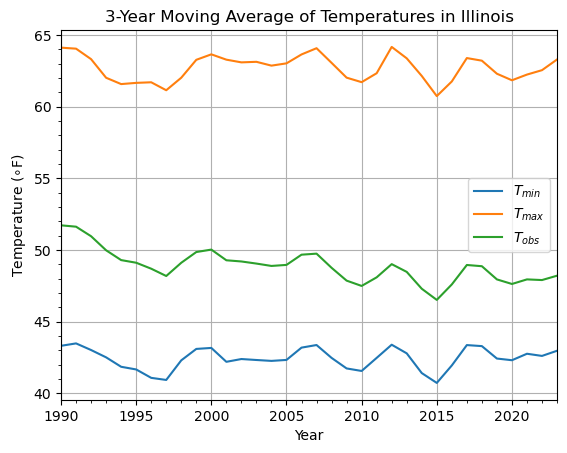

In [19]:
moving_avg_plot(resampled_temp_data, 3)

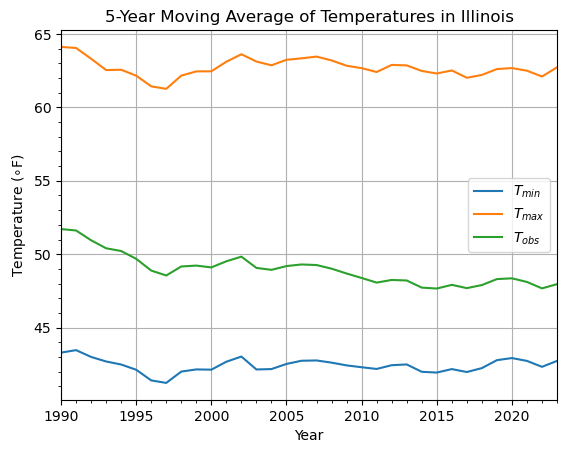

In [20]:
moving_avg_plot(resampled_temp_data, 5)

### The cell below plots the temeprature difference for the minimum, maximum, and observed temperatures.

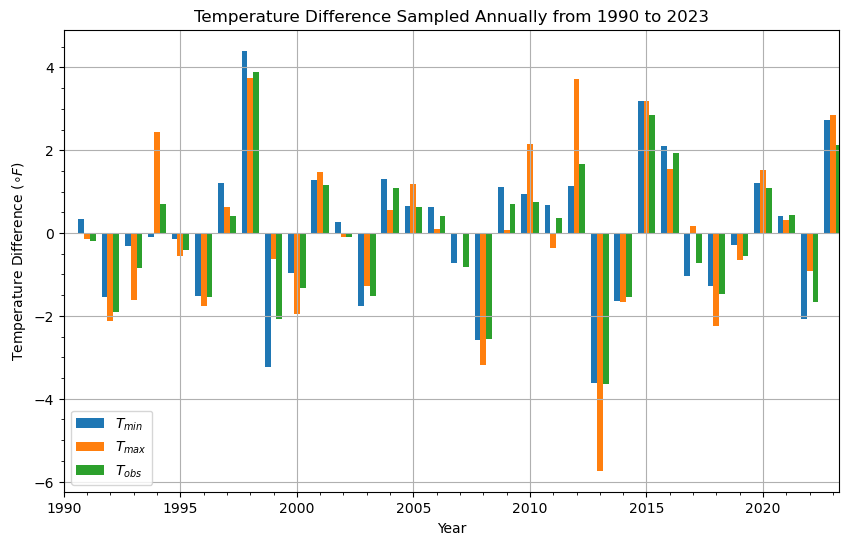

In [21]:
# Plots the temperature gradient (difference) for TMIN, TMAX, TOBS using grouped bars
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25
years = resampled_temp_data.index.year
ax.bar(years - width, resampled_temp_data["TMIN"].diff(), width=width, label=tmin_label)
ax.bar(years, resampled_temp_data["TMAX"].diff(), width=width, label=tmax_label)
ax.bar(years + width, resampled_temp_data["TOBS"].diff(), width=width, label=tobs_label)
ax.set_xlabel("Year")
ax.set_ylabel(r"Temperature Difference ($\circ F$)")
ax.legend(loc="lower left")
ax.set_xlim(years.min(), years.max() + 0.25)
ax.set_title("Temperature Difference Sampled Annually from 1990 to 2023")
ax.grid()
ax.minorticks_on()
plt.show()

In [22]:
# Correlation matrix for the desired weather pivot table
desired_weather_pivot.corr(numeric_only = True).style.background_gradient(cmap = "coolwarm", axis = None)

element,latitude,longitude,elevation,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,TSUN
element,,,,,,,,,,
latitude,1.000000,0.144943,0.719979,-0.014549,0.050923,0.162038,-0.136832,-0.125903,-0.147935,0.104612
longitude,0.144943,1.000000,0.089502,0.007380,0.013718,0.055738,0.000609,0.012903,0.031496,-0.201537
elevation,0.719979,0.089502,1.000000,-0.010638,0.038846,0.128173,-0.104953,-0.102651,-0.118238,-0.036156
PRCP,-0.014549,0.007380,-0.010638,1.000000,0.182697,-0.003349,0.076110,0.136577,0.098300,-0.031371
SNOW,0.050923,0.013718,0.038846,0.182697,1.000000,0.442490,-0.197148,-0.182236,-0.179823,-0.096278
SNWD,0.162038,0.055738,0.128173,-0.003349,0.442490,1.000000,-0.392554,-0.397116,-0.376976,-0.061934
TMAX,-0.136832,0.000609,-0.104953,0.076110,-0.197148,-0.392554,1.000000,0.932444,0.920741,0.118476
TMIN,-0.125903,0.012903,-0.102651,0.136577,-0.182236,-0.397116,0.932444,1.000000,0.939128,0.087115
TOBS,-0.147935,0.031496,-0.118238,0.098300,-0.179823,-0.376976,0.920741,0.939128,1.000000,nan


In [23]:
forecast = desired_weather_pivot.drop(columns = ["id", "name"]).copy()

In [24]:
forecast['date'] = forecast['date'].astype('int64')

In [25]:
models = {
    'lower': HistGradientBoostingRegressor(loss='quantile', quantile = 0.05),
    'median': HistGradientBoostingRegressor(loss='quantile', quantile = 0.5),
    'upper': HistGradientBoostingRegressor(loss='quantile', quantile = 0.95),
}

In [26]:
# Remove rows where TOBS is NaN
forecast = forecast.dropna(subset=['TOBS'])

# Split the data into training and testing sets
X = forecast.drop(columns=['TOBS']).values
y = forecast['TOBS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
for key in models:
    models[key].fit(X_train, y_train)

In [27]:
# Make predictions using the models
y_lower = models['lower'].predict(X_test)
y_pred = models['median'].predict(X_test)
y_upper = models['upper'].predict(X_test)

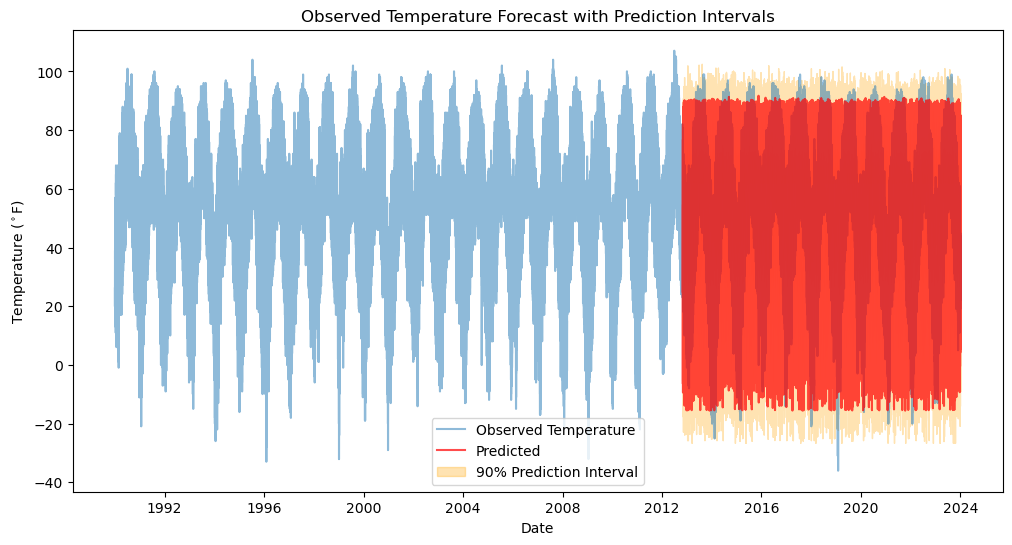

In [28]:
forecast["date"] = forecast["date"].astype('datetime64[ns]')

# Get the indices of the test set after dropping NaNs in TOBS
forecast_no_nan = forecast.dropna(subset=['TOBS'])
test_indices = (forecast_no_nan.index[-X_test.shape[0]:] 
                if len(forecast_no_nan) == X_test.shape[0] + X_train.shape[0] 
                else forecast_no_nan.index[-len(y_test):])
test_dates = forecast_no_nan.loc[test_indices, 'date']

results = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'y_lower': y_lower,
    'y_upper': y_upper
}, index=test_dates)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(forecast["date"], forecast["TOBS"], label='Observed Temperature', alpha=0.5)
plt.plot(results.index, results['y_pred'], label='Predicted', color='red', alpha=0.7)
plt.fill_between(results.index, results['y_lower'], results['y_upper'],
                 color='orange', alpha=0.3, label='90% Prediction Interval')

plt.legend()
plt.title('Observed Temperature Forecast with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel(r'Temperature ($^\circ$F)')
plt.show()

In [29]:
print(f"y_pred RMS error: {np.sqrt(mean_squared_error(y_test, y_pred)): .2f}")
print(f"y_upper RMS error: {np.sqrt(mean_squared_error(y_test, y_upper)): .2f}")
print(f"y_lower RMS error: {np.sqrt(mean_squared_error(y_test, y_lower)): .2f}")

y_pred RMS error:  5.35
y_upper RMS error:  11.52
y_lower RMS error:  10.63
